# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

/home/stone/miniconda3/envs/koopman/lib/python3.8/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.05
pole_length = 1.0
dynamics = CartpoleDynamics(dt, l=pole_length)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 500
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=20, on_iteration=on_iteration)

iteration 0 accepted 2650.1941851877964 [-1.62454836  0.04247833 -0.48509923 -1.70109293]
iteration 1 accepted 2396.939024220689 [-1.39432324 -0.56462498 -0.30190637 -1.6045096 ]
iteration 2 accepted 1982.9405235269462 [-0.48047815 -0.56767867 -0.00213925 -1.33269541]
iteration 3 accepted 1835.3721505922408 [ 0.32641811 -0.42149486  0.03399353 -1.09313032]
iteration 4 accepted 1756.8322489592135 [ 0.2113967  -0.04996622  0.16785825 -1.09221312]
iteration 5 accepted 1690.6215944949508 [ 0.06926216 -0.09380291  0.14305625 -0.93126588]
iteration 6 accepted 1677.8139544254504 [-0.04790076 -0.18587901  0.22545424 -0.83673836]
iteration 7 accepted 1644.602971639892 [-0.03509287 -0.16508051  0.22778081 -0.72458261]
iteration 8 accepted 1638.0548297103712 [-0.1103988  -0.17830163  0.22969566 -0.65642291]
iteration 9 accepted 1622.4271032885742 [-0.04445378 -0.13970255  0.25908873 -0.60085667]
iteration 10 accepted 1609.9354464798155 [-0.00506982 -0.14841528  0.26285699 -0.49412415]
iteration 1

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

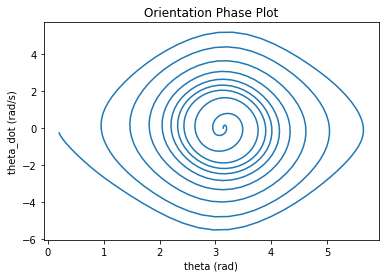

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

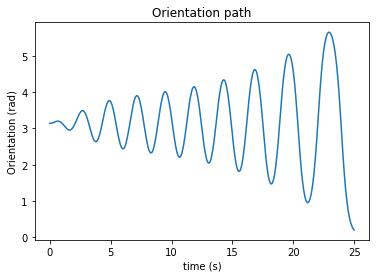

In [13]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

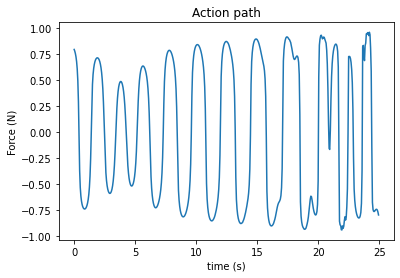

In [14]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

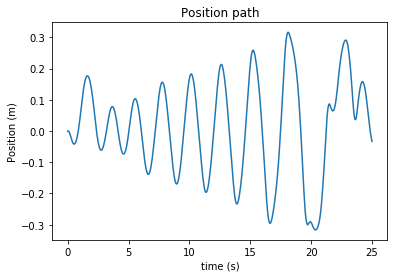

In [15]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

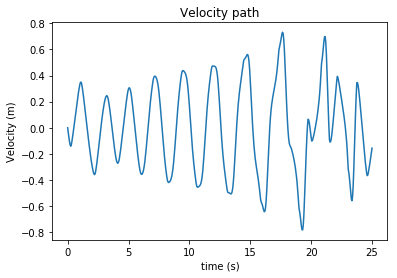

In [16]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

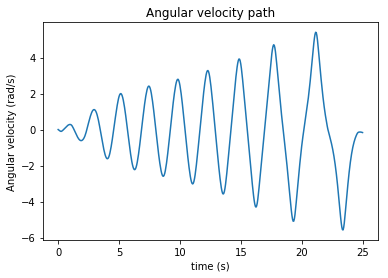

In [17]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

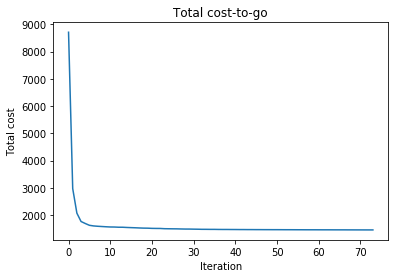

In [18]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")